In [3]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from cxr_analysis import load_results_from_log, get_cxr14_rocs_from_log

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Loading reproduce-chexnet data from file
reproduce_chexnet_results_path = '../analysis_data/reproduce_chexnet_aucs.csv'
reproduce_chexnet_results = pd.read_csv(reproduce_chexnet_results_path, 
                                        index_col='LABEL', names=['LABEL','CHEXNET-ORIG', 'CHEXNET-REPRODUCE'],
                                        header=0)
reproduce_chexnet_results.index = reproduce_chexnet_results.index.str.upper()

In [220]:
def get_cv_index(dd):
    spl = dd.split('_')
    return dd.split('_')[5] # ws 5 for 4/22
# Specify log directory to pull results from
#log_base_dir = '/lfs/1/jdunnmon/repos/metal/logs/2019_04_24'
#cv_base_name = 'cv_slice_with_roc'
log_base_dir = '/lfs/1/jdunnmon/repos/metal/logs/2019_04_22'
logs_in_folder = os.listdir(log_base_dir)
cv_base_name = 'test_cv_baseline'
cv_log_dirs = [nm for nm in logs_in_folder if cv_base_name in nm]
logs_to_load = {f"run_{get_cv_index(x)}":x for x in cv_log_dirs}

df_results_dict = {}
df_results_dict['roc-auc'] = reproduce_chexnet_results.copy()
df_results_dict['f1'] = reproduce_chexnet_results.copy()

for name, log in logs_to_load.items():
    # Loading all json logs
    results = load_results_from_log(os.path.join(log_base_dir,log))
    df_results_dict['roc-auc'] = get_cxr14_rocs_from_log(df_results_dict['roc-auc'], results['metrics'],
                                                         col_name=name, plot_metric='roc-auc', load_slices=False)
    df_results_dict['f1'] = get_cxr14_rocs_from_log(df_results_dict['f1'], results['metrics'], 
                                                    col_name=name, plot_metric='f1', load_slices=False)

In [221]:
df_results_analyze = df_results_dict['roc-auc'].round(3)

In [222]:
# Plotting drain slice performance
# (1) trained w/o slice: main head on main task
# (2) trained w/slice: main head on slice task, slice head on slice task

slice_results_dict = {}
slice_results_dict['roc-auc'] = df_results_dict['roc-auc'].copy()

df_slice = {}
for ky, log in logs_to_load.items():
    results = load_results_from_log(os.path.join(log_base_dir,log))
    if 'slice_metrics' in results.keys():
        slice_metrics = results['slice_metrics']['test']
        for head in slice_metrics:
            slice_results_dict['roc-auc'] = get_cxr14_rocs_from_log(slice_results_dict['roc-auc'], 
                                        slice_metrics[head], col_name=f"{ky}", plot_metric='roc-auc', load_slices=True, head=head)

In [223]:
cv_keys = list(logs_to_load.keys())
slice_results_dict['roc-auc']['cv_mean'] = slice_results_dict['roc-auc'].filter(cv_keys).mean(axis=1)
slice_results_dict['roc-auc']['cv_std'] = slice_results_dict['roc-auc'].filter(cv_keys).std(axis=1)
slice_results_dict['roc-auc'].round(3)

,CHEXNET-ORIG,CHEXNET-REPRODUCE,run_5,run_2,run_3,run_4,run_1,cv_mean,cv_std
LABEL,,,,,,,,,
ATELECTASIS,0.816,0.809,0.820,0.817,0.814,0.822,0.820,0.819,0.003
CARDIOMEGALY,0.910,0.925,0.913,0.915,0.913,0.911,0.915,0.913,0.002
CONSOLIDATION,0.801,0.790,0.800,0.804,0.801,0.805,0.803,0.803,0.002
EDEMA,0.898,0.888,0.898,0.895,0.898,0.899,0.897,0.897,0.002
EFFUSION,0.884,0.864,0.884,0.881,0.882,0.881,0.883,0.882,0.001
EMPHYSEMA,0.923,0.937,0.923,0.912,0.913,0.914,0.928,0.918,0.007
FIBROSIS,0.829,0.805,0.825,0.823,0.820,0.828,0.820,0.823,0.003
HERNIA,0.901,0.916,0.912,0.904,0.906,0.932,0.926,0.916,0.013
INFILTRATION,0.708,0.734,0.714,0.711,0.705,0.715,0.715,0.712,0.004


/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


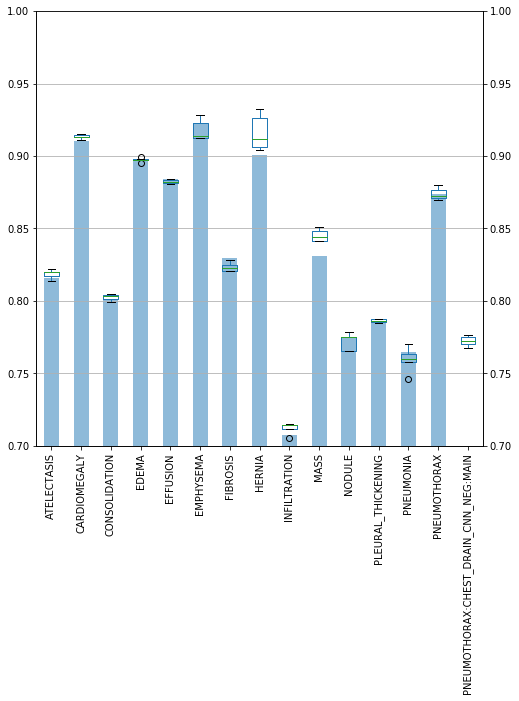

In [226]:
import numpy as np

fig, ax = plt.subplots(1,1,figsize=(8,8))
cv = [a[0] for a in slice_results_dict['roc-auc'].filter(['CHEXNET-ORIG']).values.tolist()]
ax.bar(range(1,16), cv, align='center', width=0.5,alpha=0.5)
ax2 = ax.twinx()
ax2 = slice_results_dict['roc-auc'].filter(cv_keys).T.boxplot(figsize=(10,10),rot=90)
ax.set_ylim([0.7,1])
ax2.set_ylim(ax.get_ylim())
ax.set_xticklabels(slice_results_dict['roc-auc'].index, rotation='vertical')
plt.savefig('../figures/Naive-Seeds-Compare.png',format='png', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
#ax = df_compare.plot.bar(rot=45)
save_res = False
models_to_plot = ['CHEXNET-ORIG','MTL-224','MTL-512']
#models_to_plot = ['MTL-224','MTL-224-NO-DRAIN-BASE','MTL-224-NO-DRAIN-HPS']
plot_metric = 'roc-auc'
df_plot = df_results_dict[plot_metric][models_to_plot]
f = plt.figure('ROC-AUC')
plt.title('CXR-14 Performance', color='black')
plt.ylabel(f'Test {plot_metric.upper()}')
plot = df_plot.plot(kind='bar', ax=f.gca(),rot=90)
plot.set_xlabel('')
if plot_metric == 'roc-auc':
    plot.set_ylim([0.7, 1.0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
if save_res:
    plt.savefig(f'../figures/CXR14-performance-{plot_metric}-mtl-chexnet-224-drain.png',format='png', bbox_inches='tight')
plt.show()

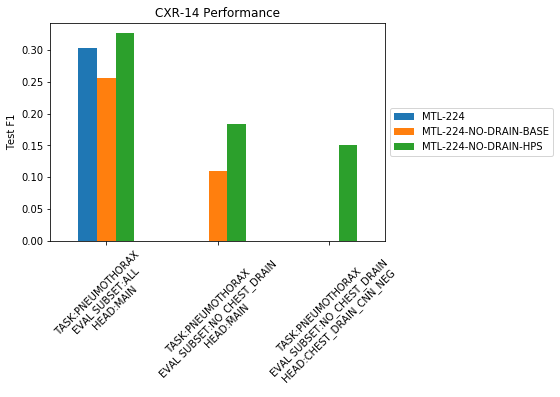

In [88]:
import matplotlib.pyplot as plt

def convert_slice_plot_names(df, slc_name):
    inds = df.index.tolist()
    for ii, ind in enumerate(inds):
        if ":" in ind:
            splt = ind.split(":")
            slc = slc_name
        else:
            splt = ind
            slc = 'ALL'
        if isinstance(splt, str):
            task, head = ind, 'MAIN'
        else:
            task, sh, head = splt
            if head == 'SLICE':
                head = sh
        inds[ii] = f'TASK:{task} \n EVAL SUBSET:{slc} \n HEAD:{head}'
    df.index = inds
    
# Save if True
save_res = True

# Getting models and tasks to plot
models_to_plot = ['MTL-224','MTL-224-NO-DRAIN-BASE','MTL-224-NO-DRAIN-HPS']
tasks_to_plot = ['PNEUMOTHORAX']
plot_metric = 'f1'
# Getting indices for all relevant slices
df_indices = [a for a in slice_results_dict[plot_metric].index if any([t in a for t in tasks_to_plot])]
# Selecting
df_plot = slice_results_dict[plot_metric][models_to_plot].loc[df_indices].copy()
# Converting names
convert_slice_plot_names(df_plot,'NO_CHEST_DRAIN')

f = plt.figure('DRAIN_SLICE')
plt.title('CXR-14 Performance', color='black')
plt.ylabel(f'Test {plot_metric.upper()}')
plot = df_plot.plot(kind='bar', ax=f.gca(),rot=45)
plot.set_xlabel('')
if plot_metric == 'roc-auc':
    plot.set_ylim([0.7, 1.0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
if save_res:
    plt.savefig(f'../figures/CXR14-performance-{plot_metric}-mtl-chexnet-224-pneumo-drain.png',format='png', bbox_inches='tight')
plt.show()

In [81]:
inds = df_plot.index.tolist()
for ii, ind in enumerate(inds):
    if ":" in ind:
        splt = ind.split(":")
    else:
        splt = ind
    if isinstance(splt, str):
        task, slc,head = ind, 'ALL', 'MAIN'
    else:
        task, slc, head = splt
    inds[ii] = f'TASK:{task} \n SLICE:{slc} \n HEAD:{head}'

ValueError: too many values to unpack (expected 3)

# SANDBOX

In [214]:
plt.savefig?

Signature: plt.savefig(*args, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, dpi=None, facecolor='w', edgecolor='w',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=None, metadata=None)

The output formats available depend on the backend being used.

Parameters
----------

fname : str or file-like object
    A string containing a path to a filename, or a Python
    file-like object, or possibly some backend-dependent object
    such as :class:`~matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is *None* and *fname* is a string, the output
    format is deduced from the extension of the filename. If
    the filename has no extension, :rc:`savefig.format` is used.

    If *fname* is not a string, remember to specify *format* to
    ensure that the correct backend is used.

Other Parameters
----------------

dpi : [ *None* | scalar > 0 | 'figure' ]
 